# Deformable Convolution (DCN)

Bu notebook'ta **Deformable Convolution (DCN)** yapısını, klasik konvolüsyonla farklarını, matematiksel modelini ve pratikte nasıl kullanılacağını adım adım inceleyeceğiz.

**Hedefler:**
- Klasik konvolüsyon ile deformable konvolüsyon arasındaki temel farkı anlamak
- Offset (kayma) mantığını ve formülünü görmek
- Deformable Conv v1 ve v2 arasındaki farkları öğrenmek
- DCN'in neden özellikle **görüntü işleme / obje tespiti** modellerinde kullanıldığını anlamak
- PyTorch tabanlı bir DCN bloğunun nasıl entegre edilebileceğini görmek (örnek kod)


## 1. Klasik Konvolüsyonun Kısıtı

Klasik 2D konvolüsyonda bir **kernel (filtre)**, her uzamsal konumda **sabit bir örnekleme ızgarası (grid)** üzerinden piksel okur.

Örneğin 3×3 bir kernel için, merkez nokta $(x, y)$ iken örneklenen sabit grid şudur:

$$\mathcal{R} = \{(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)\}$$

Klasik konvolüsyonun çıktısı:

$$y(x, y) = \sum_{k \in \mathcal{R}} w_k \cdot x(x + k_x, y + k_y)$$

Burada:
- $x$: giriş feature map
- $y$: çıkış feature map
- $w_k$: kernel ağırlıkları
- $k = (k_x, k_y)$: sabit grid içindeki ofsetler

**Sorun:** Bu sabit grid, görüntüde **şekli bozulmuş, eğilmiş, kıvrılmış** nesneleri yakalamakta sınırlı kalır. Kernel her yerde **aynı şekli** görür, sahnedeki geometriye adapte olamaz.

## 2. Deformable Convolution Fikri

Deformable Convolution'un ana fikri çok basittir:

> **Sabit örnekleme noktalarına, öğrenilebilen bir "offset" (kayma) ekleyelim.**

Yani klasik 3×3 grid yerine, her konumda **öğrenilmiş, kaymış bir grid** kullanırız.

Her grid noktasına bir **ofset vektörü** ekleriz:

$$p_k \in \mathcal{R} \quad \text{(sabit grid noktaları)}$$
$$\Delta p_k \quad \text{(öğrenilen offset)}$$

Deformable konvolüsyonun çıktısı:

$$y(p_0) = \sum_{p_k \in \mathcal{R}} w_k \cdot x(p_0 + p_k + \Delta p_k)$$

Burada:
- $p_0$: merkez konum
- $p_k$: klasik grid noktaları (ör. \{(-1,-1), ..., (1,1)\})
- $\Delta p_k$: **öğrenilen offsetler** (reel sayılar, tam piksele denk gelmek zorunda değil)

**Sonuç:**
- Kernelin "gördüğü" alan **sahnedeki nesneye göre eğilebilir, uzayabilir, kayabilir**.
- Model, aynı filtreyle **farklı şekillerdeki nesnelere otomatik uyum sağlar**.

Bu nedenle DCN, özellikle **object detection, instance segmentation, pose estimation** gibi görevlerde standart konvolüsyona göre çok daha esnektir.

## 3. Sürekli Konum ve Bilinear İnterpolasyon

Offsetler $\Delta p_k$ genelde tam sayı değildir. Örneğin:

- $\Delta p_k = (0.3, -0.7)$ gibi.

Bu yüzden $x(p_0 + p_k + \Delta p_k)$ ifadesi **görüntü gridindeki olmayan bir noktayı** referans alabilir.

Çözüm: **Bilinear interpolasyon** kullanılır.

1. $(u, v)$ sürekli koordinatını düşün.
2. En yakın 4 pikseli al: `(⌊u⌋, ⌊v⌋)`, `(⌊u⌋+1, ⌊v⌋)`, `(⌊u⌋, ⌊v⌋+1)`, `(⌊u⌋+1, ⌊v⌋+1)`
3. Bu 4 pikseli, aradaki mesafelere göre ağırlıklandır.

Böylece **deforme olmuş, sürekli koordinatlara** sahip örnekleme noktalarından yumuşak bir şekilde değer çekmiş oluruz.

## 4. Offsetler Nasıl Öğreniliyor?

Offsetler rastgele değil; kendileri de bir **konvolüsyon katmanı** tarafından üretilir.

Genel yapı:
1. Giriş feature map: $x$ (örneğin boyut: `B × C × H × W`)
2. Bir **offset üretici konvolüsyon** uygularız:

   - Kernel boyutu: $K_h × K_w$ (ör. 3×3)
   - Çıkış kanal sayısı: `2 × K_h × K_w` (çünkü her grid noktası için `(Δx, Δy)` gerekiyor)

3. Bu offset haritası, deformable konvolüsyon katmanına verilir.

Özetle:
- DCN katmanı = **normal Conv + offset conv** birleşimi gibi düşünebilirsin.
- Offset conv, sahnedeki geometriye bakarak "bu kernel noktasını biraz sağa, bunu aşağıya kaydır" demeyi öğrenir.

## 5. Deformable Conv v2 (DCNv2): Modulated Deformable Conv

DCNv1'de yalnızca **offsetler** vardı. DCNv2 ile birlikte, her grid noktası için bir de **modülasyon katsayısı** eklenir.

Eklenen yeni terim: $m_k \in [0, 1]$

Yeni formül:

$$y(p_0) = \sum_{p_k \in \mathcal{R}} m_k \cdot w_k \cdot x(p_0 + p_k + \Delta p_k)$$

Burada:
- $m_k$: Her örnekleme noktasının **önemini** belirleyen skaler (gate gibi çalışır).
- $m_k$ genelde `sigmoid` aktivasyonu ile [0,1] aralığına sıkıştırılır.

**Fark nedir?**
- Sadece nereye bakacağını değil, **hangi noktanın daha önemli olduğunu** da öğrenir.
- Gürültülü veya alakasız noktalara verilen ağırlık azaltılabilir.

**Offset + Modulation birlikte:**
- Grid geometrik olarak deforme olur.
- Aynı zamanda bazı noktalar baskılanır / bazıları vurgulanır.

## 6. Neden İşe Yarıyor? (İntuitif Bakış)

**Örnek senaryo:** Eğik bir araba plakası düşün.

Klasik konvolüsyon:
- 3×3 grid, plakanın içine tam oturmaz.
- Çizgiler, harfler gridin sınırlarına eğik bir şekilde çarpar.
- Filtre, aynı deseni her yerde dik / sabit yönde aradığı için, eğik formu yakalamakta zorlanır.

Deformable konvolüsyon:
- Offsetler, grid noktalarını **plakanın şekline uydurur**.
- Grid sanki plakanın yüzeyine yapışır gibi davranır.
- Böylece aynı filtre, farklı açıdaki / geometrisi bozulmuş nesneleri çok daha sağlam şekilde temsil eder.

**Pratik gözlemler (literatürden):**
- Obje tespit AP (Average Precision) değerlerini yükseltir.
- Özellikle **deforme, ince, kıvrımlı nesnelerde** (ör. insan pozu, kıyafet, kablo, el işaretleri) ciddi fayda sağlar.
- Fiyat: Normal konvolüsyona göre biraz daha fazla hesaplama ve parametre.

## 7. Diğer Konvolüsyonlarla Kısa Kıyaslama

| Tür | Ana Fikir | Avantaj | Dezavantaj |
|-----|----------|---------|-----------|
| Klasik Conv | Sabit grid | Basit, hızlı | Geometrik esneklik düşük |
| Dilated Conv | Grid noktalarını seyreltir, receptive field büyür | Daha geniş alan görür | Hâlâ sabit grid, deforme olamaz |
| Depthwise Separable | Kanal bazlı + pointwise | Parametre ve FLOP çok az | Geometrik esneklik aynı |
| Inverted Bottleneck | Genişlet-sıkıştır yapısı | Mobil ağlar için verimli | Geometriyi değiştirmez |
| Ghost Conv | Özellikleri cheap ops ile çoğaltır | Hız/parametre avantajı | Geometri sabit |
| **Deformable Conv** | Grid noktalarını kaydırır (offset) | Geometriye uyum, esneklik yüksek | Hesaplama ve implementasyon daha zor |

Gördüğün gibi, deformable conv'un **odak noktası geometri**. Diğer optimizasyonlar ise daha çok **hesaplama maliyeti, parametre azaltma** veya **kanal içi yapı** ile ilgili.

## 8. PyTorch ile Deformable Convolution Kullanımı (Örnek Yapı)

Deformable Convolution genelde doğrudan `nn.Conv2d` gibi PyTorch içinde gelmez. Bunun yerine:

- `torchvision.ops.DeformConv2d` (bazı sürümlerde mevcuttur)
- veya `mmcv` / `mmdet` gibi kütüphanelerin DCN implementasyonları kullanılır.

Aşağıdaki kod genel yapıyı göstermek içindir. Çalıştırmak için sisteminde uygun DCN implementasyonunun kurulu olması gerekir.


In [ ]:
# Bu hücre genel yapıyı göstermek içindir.
# Çalışması için uygun DCN implementasyonunun (ör. mmcv, torchvision.ops.DeformConv2d) sistemine kurulmuş olması gerekir.

import torch
import torch.nn as nn

class DeformableConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()

        # Offset üretici konvolüsyon
        # 2 * kernel_size * kernel_size: her nokta için (dx, dy)
        self.offset_conv = nn.Conv2d(
            in_channels,
            2 * kernel_size * kernel_size,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )

        # Burada placeholder bir DCN modülü gösteriyoruz.
        # Gerçek kullanımda buraya ilgili kütüphaneden DeformConv2d gelecektir.
        try:
            from torchvision.ops import DeformConv2d
            self.dcn = DeformConv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            )
        except Exception as e:
            raise RuntimeError("DeformConv2d bu ortamda mevcut değil. Uygun kütüphaneyi kurman gerekiyor.") from e

        self.norm = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        # Offset haritasını üret
        offset = self.offset_conv(x)
        # Deformable conv uygula
        out = self.dcn(x, offset)
        out = self.norm(out)
        out = self.act(out)
        return out

# Örnek kullanım
if __name__ == "__main__":
    x = torch.randn(1, 64, 128, 128)  # B, C, H, W
    block = DeformableConvBlock(64, 128)
    y = block(x)
    print(y.shape)  # Beklenen: (1, 128, 128, 128) stride=1 ise

torch.Size([1, 128, 128, 128])


## 9. DCN'i Backbone İçine Nerede Kullanmalıyım?

Pratikte DCN genellikle:

- **Backbone'in derin katmanlarında** (özellikle yüksek seviye feature'larda),
- Obje tespit / segmentation head'ine yakın yerlerde,
- Hesaplama maliyetinin kabul edilebilir olduğu birkaç kritik blokta

şu amaçlarla kullanılır:

1. **Geometrik karmaşıklığı yüksek nesneler** için daha esnek temsil (ör. insan vücudu, işaret dili, kıvrımlı yapılar).
2. **Farklı açılardan görülen nesnelerde** performans artışı.
3. Sabit kernel yerine **veriye uyum sağlayan, "bükülebilir" kernel davranışı**.

Örnek tasarım fikri:
- ResNet benzeri bir backbone düşün.
- Son 2–3 residual blokta normal `Conv2d` yerine `DeformableConvBlock` kullan.
- Böylece erken katmanlar hızlı ve hafif kalır, geç katmanlar ise geometriye daha duyarlı olur.

## 10. (Opsiyonel) Grid ve Offsetlerin Görselleştirilmesi

Aşağıdaki hücre, 3×3 bir kernel için klasik grid noktalarını ve örnek bir offset eklenmiş deforme grid'i 2D düzlemde çizmeyi gösterir. Bu sadece **geometrik sezgi** kazanmak içindir.

Not: Bu hücreyi çalıştırmak için `matplotlib` yüklü olmalıdır.

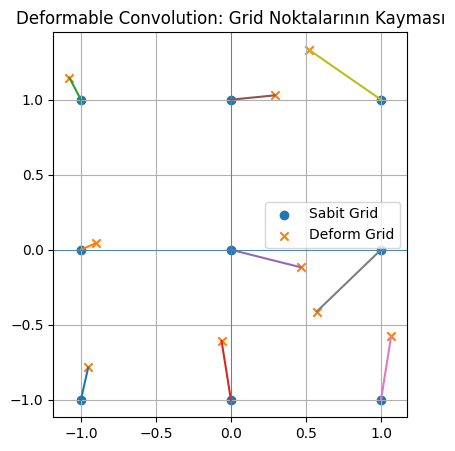

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Klasik 3x3 grid
base_points = np.array([
    [-1, -1], [-1, 0], [-1, 1],
    [ 0, -1], [ 0, 0], [ 0, 1],
    [ 1, -1], [ 1, 0], [ 1, 1],
], dtype=float)

# Örnek offsetler (rastgele)
np.random.seed(0)
offsets = (np.random.rand(*base_points.shape) - 0.5) * 1.0  # -0.5 ile 0.5 arası

deformed_points = base_points + offsets

plt.figure(figsize=(5, 5))
plt.scatter(base_points[:, 0], base_points[:, 1], label="Sabit Grid", marker="o")
plt.scatter(deformed_points[:, 0], deformed_points[:, 1], label="Deform Grid", marker="x")

for i in range(len(base_points)):
    x1, y1 = base_points[i]
    x2, y2 = deformed_points[i]
    plt.plot([x1, x2], [y1, y2])

plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.legend()
plt.title("Deformable Convolution: Grid Noktalarının Kayması")
plt.gca().set_aspect('equal', 'box')
plt.grid(True)
plt.show()


## 11. Özet

**Deformable Convolution'un ana fikirlerini toparlayalım:**

1. Klasik konvolüsyon sabit bir örnekleme grid'i kullanır → **geometrik esneklik sınırlı**.
2. DCN, her grid noktası için **öğrenilen offsetler** ekler → grid sahnedeki nesneye göre **bükülebilir** hale gelir.
3. DCNv2 ile birlikte offsetlere ek olarak **modülasyon maskesi** gelir → bazı noktalar daha önemli, bazıları daha önemsiz hale getirilebilir.
4. Offsetler, genelde ayrı bir konvolüsyon katmanı ile giriş feature map üzerinden üretilir.
5. DCN özellikle:
   - Obje tespit (detection)
   - Instance/semantic segmentation
   - Pose estimation, işaret dili, insan vücudu gibi deforme yapılarda
   görevlerinde ciddi fayda sağlar.
6. Maliyet: Normal conv'a göre daha ağır ama backbone içinde birkaç kritik bloğa eklenirse **fayda/maliyet oranı** iyidir.

